In [45]:
import os
import librosa
import math
import json
import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm import tqdm
from IPython.display import clear_output
import os
import pickle

In [46]:
dataset_path = r"./Data/genres_original"
json_path = r"./data.json"
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

## Preparation

- Extract Mel-Frequency Cepstral Coefficients (MFCCs) which are features of the audio files


In [47]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048,
             hop_length=512, num_segments=10):
    # Data storage dictionary
  data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
      }
  samples_ps = int(SAMPLES_PER_TRACK/num_segments) # ps = per segment
  expected_vects_ps = math.ceil(samples_ps/hop_length)

    # loop through all the genres
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
    # ensuring not at root
    if dirpath is not dataset_path:
        # save the semantic label
        dirpath_comp = dirpath.split("/")
        semantic_label = dirpath_comp[-1]
        data["mapping"].append(semantic_label)

        # Create a tqdm progress bar for the filenames
        with tqdm(total=len(filenames), desc=f"Processing: {semantic_label}") as pbar:
            # process files for specific genre
            for f in filenames:
                if f == str("jazz.00054.wav"):
                    # As librosa only reads files <1Mb
                    continue
                else:
                    # load audio file
                    file_path = os.path.join(dirpath, f)
                    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                    for s in range(num_segments):
                        start_sample = samples_ps * s
                        finish_sample = start_sample + samples_ps

                        mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],
                                                    sr=sr,
                                                    n_fft=n_fft,
                                                    n_mfcc=n_mfcc,
                                                    hop_length=hop_length)

                        mfcc = mfcc.T

                        # store mfcc if it has expected length
                        if len(mfcc)==expected_vects_ps:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            #print(f"{file_path}, segment: {s+1}")
                            pbar.update(1)

    with open(json_path,"w") as f:
        json.dump(data,f,indent=4)
                        #if len(mfcc) == expected_vects_ps:
                            #data["mfcc"].append(mfcc.tolist())
                            #data["labels"].append(i-1)


In [48]:
pip install soundfile


Note: you may need to restart the kernel to use updated packages.


In [49]:


pickle_path = 'mfcc_pickle.p'

if os.path.exists(pickle_path):
    # Load data from pickle file
    with open(pickle_path, 'rb') as fp:
        data = pickle.load(fp)
else:
    # Compute and save data to pickle file
    data = save_mfcc(dataset_path, json_path, num_segments=10)
    with open(pickle_path, 'wb') as fp:
        pickle.dump(data, fp)

clear_output()

In [50]:
file_path = r"./Data/genres_original/blues/blues.0000"

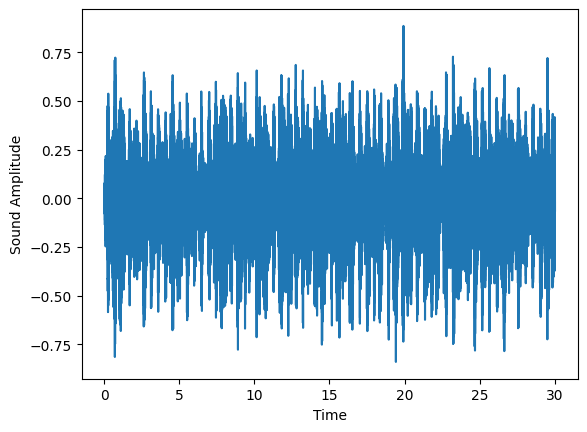

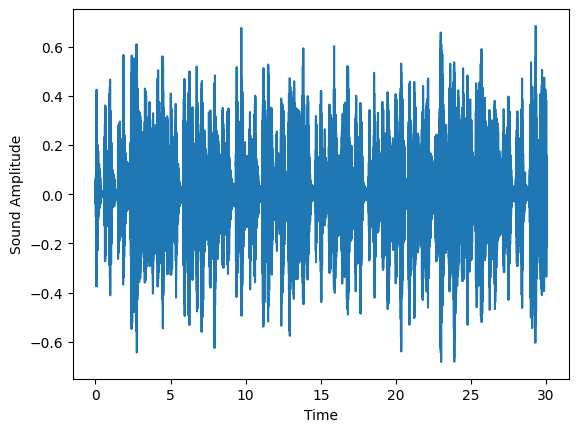

In [51]:
for i in range(2):
    audio, sfreq = librosa.load(file_path+str(i)+".wav")
    time = np.arange(0, len(audio))/sfreq
    plt.plot(time,audio)
    plt.xlabel("Time")
    plt.ylabel("Sound Amplitude")
    plt.show()

## Data Augmentation


In [52]:
# load data
def load_data(dataset_path):
    with open(dataset_path,"r") as f:
        data = json.load(f)

    # Convert list to numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])

    return inputs,targets

In [53]:
inputs, targets = load_data(json_path)
print("input shape:", inputs.shape)

input shape: (9986, 130, 13)


In [54]:
## Split data into train and test sets
# splitting the data
from sklearn.model_selection import train_test_split

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)
print(input_train.shape, target_train.shape)




(6990, 130, 13) (6990,)


In [55]:
# build the network architecture

from tensorflow.keras import Sequential
from tensorflow.keras.layers import *


In [56]:
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1690)              0         
                                                                 
 dense (Dense)               (None, 512)               865792    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 1014218 (3.87 MB)
Trainable params: 1014218 (3.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(learning_rate=1e-4)

In [58]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(lr=1e-4)

In [59]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [60]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)
clear_output()

In [61]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

<Figure size 2000x1500 with 0 Axes>

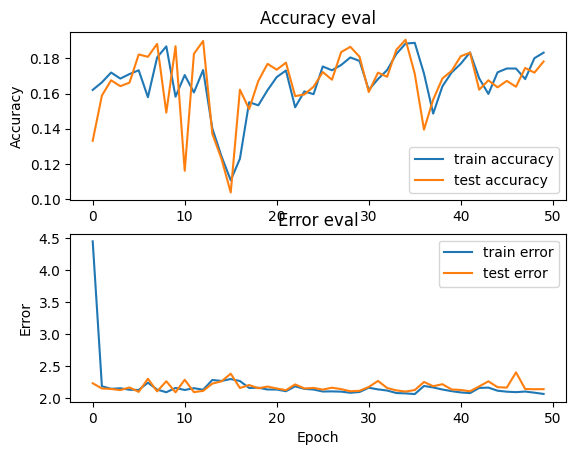

In [62]:
plot_history(hist)

In [63]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 [==============================] - 0s 1ms/step - loss: 2.1407 - accuracy: 0.1782
Test accuracy: 0.178237646818161


2023-11-03 07:28:08.827974: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20252960 exceeds 10% of free system memory.


## Overfitting

This part deals with the overfitting of the previous model. We can deal with it by majorly doing the following process.

Making architecture less complicated
Using augmented data
Early stopping of training
Adding dropout layers
Regularization / Standardization
I have added the dropout layers and kernel_regularizers as compared to previous naive model giving the dropout probability as 30% Kernel_regularizers is one of the 3 type of regularizer used to impose penalties. More info can be found


In [64]:
import tensorflow.keras as keras

In [65]:
# Overfitting

model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(0.003)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1690)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               865792    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)               

In [66]:
from keras.optimizers import Adam

adam = Adam(learning_rate=0.001)

model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)

clear_output()

<Figure size 2000x1500 with 0 Axes>

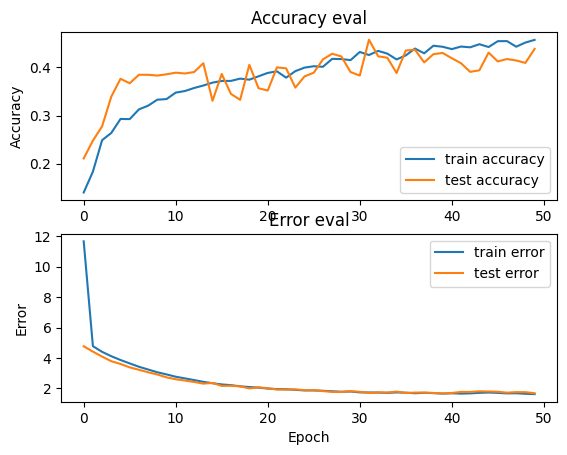

In [67]:
plot_history(hist)

In [68]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

39/94 [===========>..................] - ETA: 0s - loss: 1.7159 - accuracy: 0.4287

2023-11-03 07:29:35.813737: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20252960 exceeds 10% of free system memory.


94/94 [==============================] - 0s 3ms/step - loss: 1.6867 - accuracy: 0.4386
Test accuracy: 0.4385847747325897


[ ]
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")
CNN Using keras layers of Conv2D, MaxPool2D, BatchNormalization.

CNN layers takes input primarily in 3D shape, so we again have to prepare the dataset in the form and for that, I have used np.newaxis function which adds a column/layer in the data


In [69]:
def prepare_dataset(test_size, validation_size):
    X,y = load_data(r"./data.json")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [70]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2)

In [71]:
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)

(130, 13, 1)


In [72]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 6, 64)         0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 6, 64)         256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 2, 32)         0         
 g2D)                                                            
                                                      

In [73]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

hist = model.fit(X_train, y_train,
                 validation_data = (X_val, y_val),
                 epochs = 40,
                 batch_size = 32)

Epoch 1/40
188/188 [==============================] - 14s 67ms/step - loss: 1.8571 - accuracy: 0.3450 - val_loss: 1.4820 - val_accuracy: 0.4566
Epoch 2/40
188/188 [==============================] - 10s 52ms/step - loss: 1.4160 - accuracy: 0.4882 - val_loss: 1.2167 - val_accuracy: 0.5507
Epoch 3/40
188/188 [==============================] - 9s 48ms/step - loss: 1.2452 - accuracy: 0.5508 - val_loss: 1.1418 - val_accuracy: 0.5988
Epoch 4/40
188/188 [==============================] - 9s 46ms/step - loss: 1.1502 - accuracy: 0.5885 - val_loss: 1.0310 - val_accuracy: 0.6288
Epoch 5/40
188/188 [==============================] - 8s 44ms/step - loss: 1.0528 - accuracy: 0.6269 - val_loss: 1.0221 - val_accuracy: 0.6368
Epoch 6/40
188/188 [==============================] - 8s 42ms/step - loss: 0.9866 - accuracy: 0.6510 - val_loss: 1.0095 - val_accuracy: 0.6322
Epoch 7/40
188/188 [==============================] - 8s 40ms/step - loss: 0.9157 - accuracy: 0.6758 - val_loss: 0.9635 - val_accuracy: 0.66

<Figure size 2000x1500 with 0 Axes>

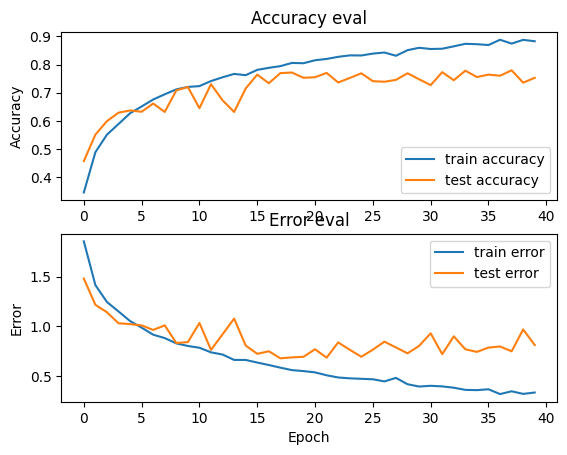

In [74]:
plot_history(hist)

In [75]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

79/79 [==============================] - 1s 8ms/step - loss: 0.8142 - accuracy: 0.7525
Test accuracy: 0.752502977848053


In [76]:
def predict(model, X, y):
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")

In [77]:
predict(model, X_test[10], y_test[10])

1/1 [==============================] - 0s 122ms/step
Expected index: 9, Predicted index: [9]
